# Uplift Modeling to predict and target the right customers
![](https://st2.ning.com/topology/rest/1.0/file/get/2220280883?profile=original)
[Uplift modelling](https://en.wikipedia.org/wiki/Uplift_modelling), also known as incremental modelling, true lift modelling, or net modelling is a predictive modelling technique that directly models the incremental impact of a treatment (such as a direct marketing action) on an individual's behaviour.

# Setup

In [49]:
# Import libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns, math, os


In [65]:
!pip install causalml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.4 MB/s eta 0:00:00


# Data Exploration

In [126]:
# Import data
df_data = pd.read_csv('/content/data.csv')
df = df_data.copy()

In [127]:
# Let's take a look at our data
df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [128]:
# Checking for null data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


No null values in the dataset

In [129]:
def column_summary(df):
    summary_data = []

    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()

        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'distinct_values_counts': distinct_values_counts
        })

    summary_df = pd.DataFrame(summary_data)
    return summary_df

# Example usage:
# Assuming df is your DataFrame
summary = column_summary(df)

In [130]:
summary

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
0,recency,int64,0,64000,12,"{1: 8952, 10: 7565, 2: 7537, 9: 6441, 3: 5904,..."
1,history,float64,0,64000,34833,"{29.99: 7947, 81.2: 9, 53.79: 9, 44.14: 8, 60...."
2,used_discount,int64,0,64000,2,"{1: 35266, 0: 28734}"
3,used_bogo,int64,0,64000,2,"{1: 35182, 0: 28818}"
4,zip_code,object,0,64000,3,"{'Surburban': 28776, 'Urban': 25661, 'Rural': ..."
5,is_referral,int64,0,64000,2,"{1: 32144, 0: 31856}"
6,channel,object,0,64000,3,"{'Web': 28217, 'Phone': 28021, 'Multichannel':..."
7,offer,object,0,64000,3,"{'Buy One Get One': 21387, 'Discount': 21307, ..."
8,conversion,int64,0,64000,2,"{0: 54606, 1: 9394}"


In [131]:
summary.iloc[7]['distinct_values_counts']

{'Buy One Get One': 21387, 'Discount': 21307, 'No Offer': 21306}

Renaming columns

conversion => target

offer => treatment

In [132]:
# Rename target column
df = df.rename(columns={'conversion': 'target'})
# Rename & Label encode treatment column
df = df.rename(columns={'offer': 'treatment'})
df.treatment = df.treatment.map({'No Offer': 0, 'Buy One Get One': -1, 'Discount': 1})

Encoding the categorical variables

In [133]:
# One-Hot Encoding:
df = pd.get_dummies(df)

separting the dataframes.

One willl be discount and no offer

other will be bogo and no offer


In [134]:
# Split data with bogo and discount
df_bogo = df.copy().loc[df.treatment <=0].reset_index(drop=True)
df_discount = df.copy().loc[df.treatment >=0].reset_index(drop=True)

# Discount

In [135]:
df_discount['target'].value_counts(normalize = True)

,proportion
target,
0,0.855537
1,0.144463


In [136]:
df_discount['treatment'].value_counts(normalize = True)

,proportion
treatment,
1,0.500012
0,0.499988


Conversion Rate Analysis: Treatment vs. Control Groups

Treatment Group: Participants who received the intervention (treatment = 1)

Control Group: Participants who did not receive the intervention (treatment = 0)

In [137]:
treatment_group = df_discount[df_discount['treatment'] == 1 ]
control_group = df_discount[df_discount['treatment'] == 0]

# Number of users and conversion rate in treatment group
treatment_converted = treatment_group['target'].sum()
treatment_total = len(treatment_group)
treatment_conversion_rate = treatment_converted / treatment_total

# Number of users and conversion rate in control group
control_converted = control_group['target'].sum()
control_total = len(control_group)
control_conversion_rate = control_converted / control_total

# Create a summary table
summary_table = pd.DataFrame({
    '': ['Total Users', 'Converted Users', 'Conversion Rate (%)'],
    'Treatment Group': [treatment_total, treatment_converted, f"{treatment_conversion_rate * 100:.2f}%"],
    'Control Group': [control_total, control_converted, f"{control_conversion_rate * 100:.2f}%"]
})
display(summary_table)

# Difference in conversion rate
conversion_rate_difference = treatment_conversion_rate - control_conversion_rate
print(f"Difference in Conversion Rate between Treatment and Control Groups: {conversion_rate_difference * 100:.2f}% "
      f"(Treatment: {treatment_conversion_rate * 100:.2f}%, Control: {control_conversion_rate * 100:.2f}%)")
print("Note: This is the simple difference in conversion rates and not the true treatment effect.")

,,Treatment Group,Control Group
0,Total Users,21307,21306
1,Converted Users,3894,2262
2,Conversion Rate (%),18.28%,10.62%


Difference in Conversion Rate between Treatment and Control Groups: 7.66% (Treatment: 18.28%, Control: 10.62%)
Note: This is the simple difference in conversion rates and not the true treatment effect.


The naive ATE is 7.66% and it is not true treatment effect

Estimating the Average Treatment Effect (ATE) using a T-Learner with XGBoost

In [138]:
from causalml.inference.meta import XGBTRegressor
feature_columns = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
                   'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
                   'channel_Multichannel', 'channel_Phone', 'channel_Web']

# Extract X, y, and treatment
X = df_discount[feature_columns]
y = df_discount['target']  # This is your conversion column
treatment = df_discount['treatment']
# Initialize and fit the T-Learner with XGBoost
learner_t = XGBTRegressor()
learner_t.fit(X=X.values, treatment=treatment.values, y=y.values)

# Predict the treatment effect and calculate the Average Treatment Effect (ATE)
treatment_effect = learner_t.predict(X=X.values)
ate = treatment_effect.mean()

# Output the estimated ATE as a percentage
print(f"Estimated ATE: {ate * 100:.2f}%")

Estimated ATE: 7.48%


The estimated ATE is 7.48%, slightly lower than the simple aggregation result of 7.66%, accounting for customers who would have purchased regardless of seeing the advertisement.

In [139]:
df_discount.columns

Index(['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
       'treatment', 'target', 'zip_code_Rural', 'zip_code_Surburban',
       'zip_code_Urban', 'channel_Multichannel', 'channel_Phone',
       'channel_Web'],
      dtype='object')

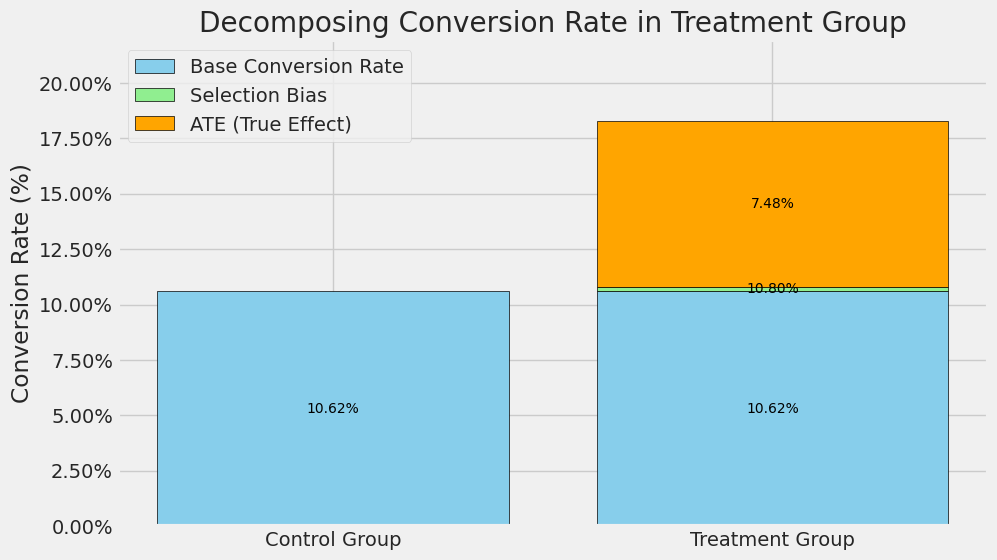

In [140]:
selection_bias = treatment_conversion_rate - ate

# Plotting the results
fig, ax = plt.subplots(figsize=(10, 6))

# Stacked bars for Treatment Group
base_conversion = control_conversion_rate
selection_bias_height = selection_bias - control_conversion_rate
ate_height = ate

# Create the bar plot
ax.bar('Control Group', control_conversion_rate, color='skyblue', edgecolor='black', label='Base Conversion Rate')
ax.bar('Treatment Group', base_conversion, color='skyblue', edgecolor='black')  # No label to avoid duplication
ax.bar('Treatment Group', selection_bias_height, bottom=base_conversion, color='lightgreen', edgecolor='black', label='Selection Bias')
ax.bar('Treatment Group', ate_height, bottom=base_conversion + selection_bias_height, color='orange', edgecolor='black', label='ATE (True Effect)')

# Adding text labels for each segment
ax.text(0, control_conversion_rate / 2, f'{control_conversion_rate * 100:.2f}%', ha='center', va='center', color='black', fontsize=10)
ax.text(1, base_conversion / 2, f'{base_conversion * 100:.2f}%', ha='center', va='center', color='black', fontsize=10)
ax.text(1, base_conversion + selection_bias_height / 2, f'{selection_bias * 100:.2f}%', ha='center', va='center', color='black', fontsize=10)
ax.text(1, base_conversion + selection_bias_height + ate_height / 2, f'{ate * 100:.2f}%', ha='center', va='center', color='black', fontsize=10)

# Customizing plot
ax.set_ylim(0, treatment_conversion_rate * 1.2)
ax.set_ylabel('Conversion Rate (%)')
ax.set_title('Decomposing Conversion Rate in Treatment Group')

# Adding legend
ax.legend()

# Format y-axis to show percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.2f}%'.format(y * 100)))

plt.show()

In [141]:
df_discount.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42613 entries, 0 to 42612
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   recency               42613 non-null  int64  
 1   history               42613 non-null  float64
 2   used_discount         42613 non-null  int64  
 3   used_bogo             42613 non-null  int64  
 4   is_referral           42613 non-null  int64  
 5   treatment             42613 non-null  int64  
 6   target                42613 non-null  int64  
 7   zip_code_Rural        42613 non-null  bool   
 8   zip_code_Surburban    42613 non-null  bool   
 9   zip_code_Urban        42613 non-null  bool   
 10  channel_Multichannel  42613 non-null  bool   
 11  channel_Phone         42613 non-null  bool   
 12  channel_Web           42613 non-null  bool   
dtypes: bool(6), float64(1), int64(6)
memory usage: 2.5 MB


In [142]:
df_discount['treatment'] = df_discount['treatment'].map({0: 'control', 1: 'treatment'})

In [143]:
from causalml.inference.tree import UpliftRandomForestClassifier
# Split data into training and testing sets
X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(
    df_discount.drop(columns = ['target', 'treatment']), df_discount['target'], df_discount['treatment'],
    test_size=0.3, random_state=42)
X_train_encoded = pd.get_dummies(X_train)
# Train Uplift Random Forest model
uplift_rf = UpliftRandomForestClassifier(control_name='control')
uplift_rf.fit(X_train.values, treatment=treatment_train.values, y=y_train.values)

# Predict uplift using the trained model
y_pred = uplift_rf.predict(X_test)

In [144]:
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

# Specify a tree in the random forest (the index can be any integer from 0 to n_estimators-1)
uplift_tree = uplift_rf.uplift_forest[0]

# Print uplift tree as a string
result = uplift_tree_string(uplift_tree.fitted_uplift_tree, X_train.columns)

is_referraltreatment_group_key >= 0.1?
yes -> recencytreatment_group_key >= 5.0?
		yes -> historytreatment_group_key >= 365.90600000000006?
				yes -> historytreatment_group_key >= 748.618?
						yes -> [np.float64(0.1419753086419753), np.float64(0.15723270440251572)]
						no  -> [np.float64(0.08532934131736528), np.float64(0.21138211382113822)]
				no  -> recencytreatment_group_key >= 11.3?
						yes -> [np.float64(0.01762114537444934), np.float64(0.13247863247863248)]
						no  -> [np.float64(0.038262668045501554), np.float64(0.114603798297315)]
		no  -> used_bogotreatment_group_key >= 0.1?
				yes -> historytreatment_group_key >= 89.016?
						yes -> [np.float64(0.13277742142398974), np.float64(0.2515802781289507)]
						no  -> [np.float64(0.045346062052505964), np.float64(0.16893732970027248)]
				no  -> historytreatment_group_key >= 961.43?
						yes -> [np.float64(0.0410958904109589), np.float64(0.2)]
						no  -> [np.float64(0.0976882923191648), np.float64(0.1307237813884786)]


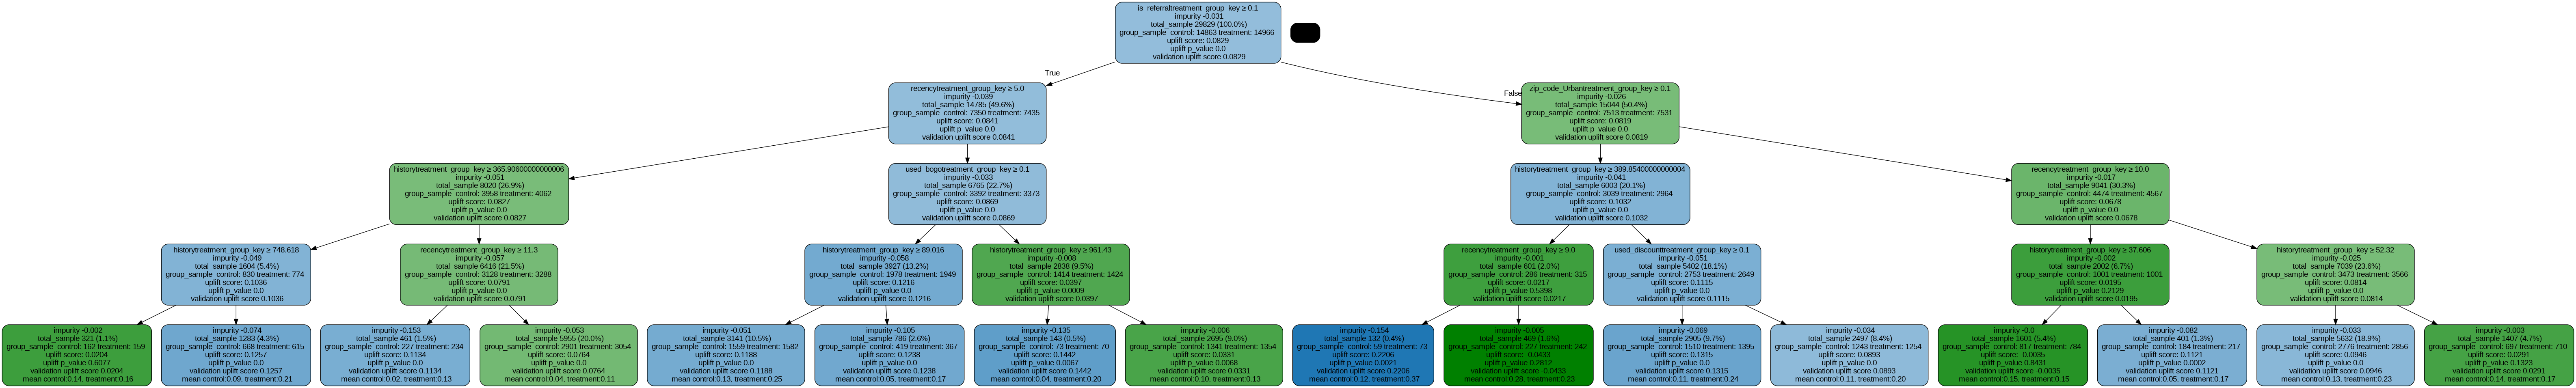

In [145]:
# Plot uplift tree
from IPython.display import Image
graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree, X_train.columns)
Image(graph.create_png())

In [147]:
uplift_results = pd.DataFrame(y_pred, columns=uplift_rf.classes_[1:])

best_treatment = np.where(uplift_results['treatment'] < 0, 'control', 'treated')

auuc_metrics = (uplift_results.assign(is_treated=(treatment_test.values != 'control').astype(int),
                              conversion=pd.concat([X_test, y_test, treatment_test], axis=1)['target'].values,
                              uplift=uplift_results.max(axis=1))
                .drop(columns=list(uplift_rf.classes_[1:])))

# Print AUUC metrics DataFrame
print("AUUC metrics DataFrame:")
display(auuc_metrics)

AUUC metrics DataFrame:


,is_treated,conversion,uplift
0,0,0,0.068958
1,1,0,0.073604
2,0,0,0.077721
3,1,1,0.059027
4,1,0,0.068716
...,...,...,...
12779,0,0,0.058547
12780,0,0,0.085674
12781,0,0,0.066338
12782,0,0,0.066033


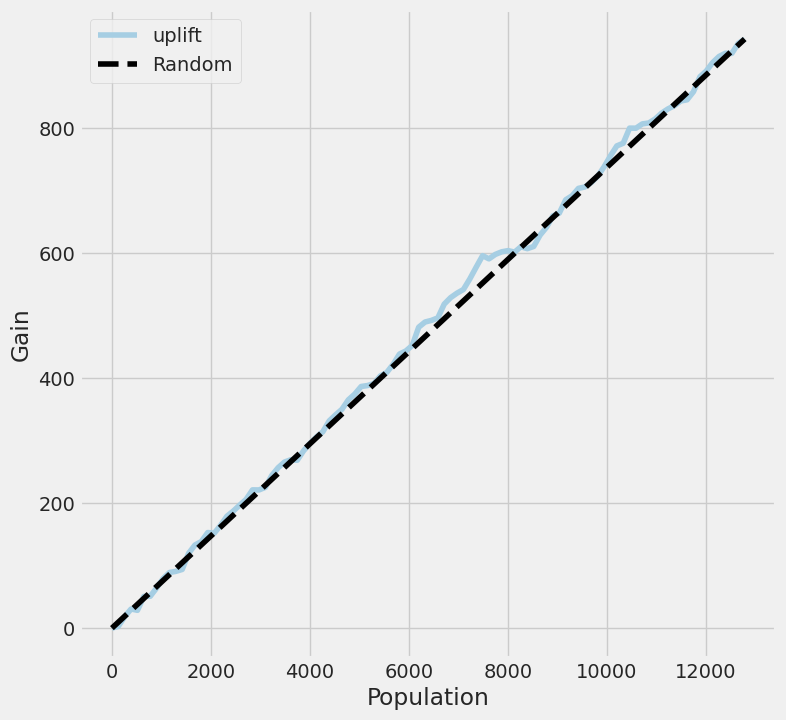

In [149]:
# Plot the uplift curve
from causalml.metrics import plot_gain, plot_qini
plot_gain(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')

In [152]:
from causalml.metrics import auuc_score
score = auuc_score(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')
print(score)

uplift    0.507532
dtype: float64


BOGO


In [153]:
df_bogo['target'].value_counts(normalize = True)

,proportion
target,
0,0.871173
1,0.128827


In [154]:
df_bogo['treatment'].value_counts(normalize = True)

,proportion
treatment,
-1,0.500949
0,0.499051


In [155]:
treatment_group = df_bogo[df_bogo['treatment'] == -1 ]
control_group = df_bogo[df_bogo['treatment'] == 0]

# Number of users and conversion rate in treatment group
treatment_converted = treatment_group['target'].sum()
treatment_total = len(treatment_group)
treatment_conversion_rate = treatment_converted / treatment_total

# Number of users and conversion rate in control group
control_converted = control_group['target'].sum()
control_total = len(control_group)
control_conversion_rate = control_converted / control_total

# Create a summary table
summary_table = pd.DataFrame({
    '': ['Total Users', 'Converted Users', 'Conversion Rate (%)'],
    'Treatment Group': [treatment_total, treatment_converted, f"{treatment_conversion_rate * 100:.2f}%"],
    'Control Group': [control_total, control_converted, f"{control_conversion_rate * 100:.2f}%"]
})
display(summary_table)

# Difference in conversion rate
conversion_rate_difference = treatment_conversion_rate - control_conversion_rate
print(f"Difference in Conversion Rate between Treatment and Control Groups: {conversion_rate_difference * 100:.2f}% "
      f"(Treatment: {treatment_conversion_rate * 100:.2f}%, Control: {control_conversion_rate * 100:.2f}%)")
print("Note: This is the simple difference in conversion rates and not the true treatment effect.")

,,Treatment Group,Control Group
0,Total Users,21387,21306
1,Converted Users,3238,2262
2,Conversion Rate (%),15.14%,10.62%


Difference in Conversion Rate between Treatment and Control Groups: 4.52% (Treatment: 15.14%, Control: 10.62%)
Note: This is the simple difference in conversion rates and not the true treatment effect.


In [156]:
from causalml.inference.meta import XGBTRegressor
feature_columns = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
                   'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
                   'channel_Multichannel', 'channel_Phone', 'channel_Web']

# Extract X, y, and treatment
X = df_bogo[feature_columns]
y = df_bogo['target']  # This is your conversion column
treatment = df_bogo['treatment']
# Initialize and fit the T-Learner with XGBoost
learner_t = XGBTRegressor()
learner_t.fit(X=X.values, treatment=treatment.values, y=y.values)

# Predict the treatment effect and calculate the Average Treatment Effect (ATE)
treatment_effect = learner_t.predict(X=X.values)
ate = treatment_effect.mean()

# Output the estimated ATE as a percentage
print(f"Estimated ATE: {ate * 100:.2f}%")

Estimated ATE: 4.41%


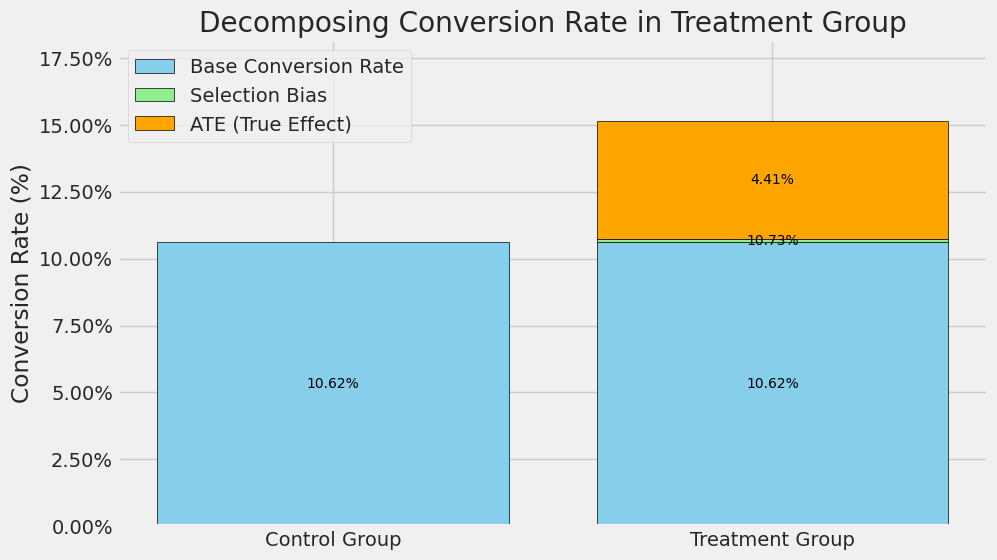

In [157]:
selection_bias = treatment_conversion_rate - ate

# Plotting the results
fig, ax = plt.subplots(figsize=(10, 6))

# Stacked bars for Treatment Group
base_conversion = control_conversion_rate
selection_bias_height = selection_bias - control_conversion_rate
ate_height = ate

# Create the bar plot
ax.bar('Control Group', control_conversion_rate, color='skyblue', edgecolor='black', label='Base Conversion Rate')
ax.bar('Treatment Group', base_conversion, color='skyblue', edgecolor='black')  # No label to avoid duplication
ax.bar('Treatment Group', selection_bias_height, bottom=base_conversion, color='lightgreen', edgecolor='black', label='Selection Bias')
ax.bar('Treatment Group', ate_height, bottom=base_conversion + selection_bias_height, color='orange', edgecolor='black', label='ATE (True Effect)')

# Adding text labels for each segment
ax.text(0, control_conversion_rate / 2, f'{control_conversion_rate * 100:.2f}%', ha='center', va='center', color='black', fontsize=10)
ax.text(1, base_conversion / 2, f'{base_conversion * 100:.2f}%', ha='center', va='center', color='black', fontsize=10)
ax.text(1, base_conversion + selection_bias_height / 2, f'{selection_bias * 100:.2f}%', ha='center', va='center', color='black', fontsize=10)
ax.text(1, base_conversion + selection_bias_height + ate_height / 2, f'{ate * 100:.2f}%', ha='center', va='center', color='black', fontsize=10)

# Customizing plot
ax.set_ylim(0, treatment_conversion_rate * 1.2)
ax.set_ylabel('Conversion Rate (%)')
ax.set_title('Decomposing Conversion Rate in Treatment Group')

# Adding legend
ax.legend()

# Format y-axis to show percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.2f}%'.format(y * 100)))

plt.show()

In [158]:
df_bogo['treatment'] = df_bogo['treatment'].map({0: 'control', -1: 'treatment'})

In [160]:
from causalml.inference.tree import UpliftRandomForestClassifier
# Split data into training and testing sets
X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(
    df_bogo.drop(columns = ['target', 'treatment']), df_bogo['target'], df_bogo['treatment'],
    test_size=0.3, random_state=42)
X_train_encoded = pd.get_dummies(X_train)
# Train Uplift Random Forest model
uplift_rf = UpliftRandomForestClassifier(control_name='control')
uplift_rf.fit(X_train.values, treatment=treatment_train.values, y=y_train.values)

# Predict uplift using the trained model
y_pred = uplift_rf.predict(X_test)

In [161]:
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

# Specify a tree in the random forest (the index can be any integer from 0 to n_estimators-1)
uplift_tree = uplift_rf.uplift_forest[0]

# Print uplift tree as a string
result = uplift_tree_string(uplift_tree.fitted_uplift_tree, X_train.columns)

used_bogotreatment_group_key >= 0.1?
yes -> recencytreatment_group_key >= 9.0?
		yes -> is_referraltreatment_group_key >= 0.1?
				yes -> channel_Phonetreatment_group_key >= 0.1?
						yes -> [np.float64(0.025597269624573378), np.float64(0.1317157712305026)]
						no  -> [np.float64(0.07288135593220339), np.float64(0.14009661835748793)]
				no  -> historytreatment_group_key >= 370.5360000000003?
						yes -> [np.float64(0.022222222222222223), np.float64(0.2786885245901639)]
						no  -> [np.float64(0.10300429184549356), np.float64(0.18047079337401917)]
		no  -> zip_code_Ruraltreatment_group_key >= 0.1?
				yes -> historytreatment_group_key >= 31.558000000000003?
						yes -> [np.float64(0.17402945113788487), np.float64(0.21092757306226176)]
						no  -> [np.float64(0.2222222222222222), np.float64(0.1111111111111111)]
				no  -> historytreatment_group_key >= 217.22?
						yes -> [np.float64(0.13933764135702748), np.float64(0.21711635750421585)]
						no  -> [np.float64(0.102177554438860

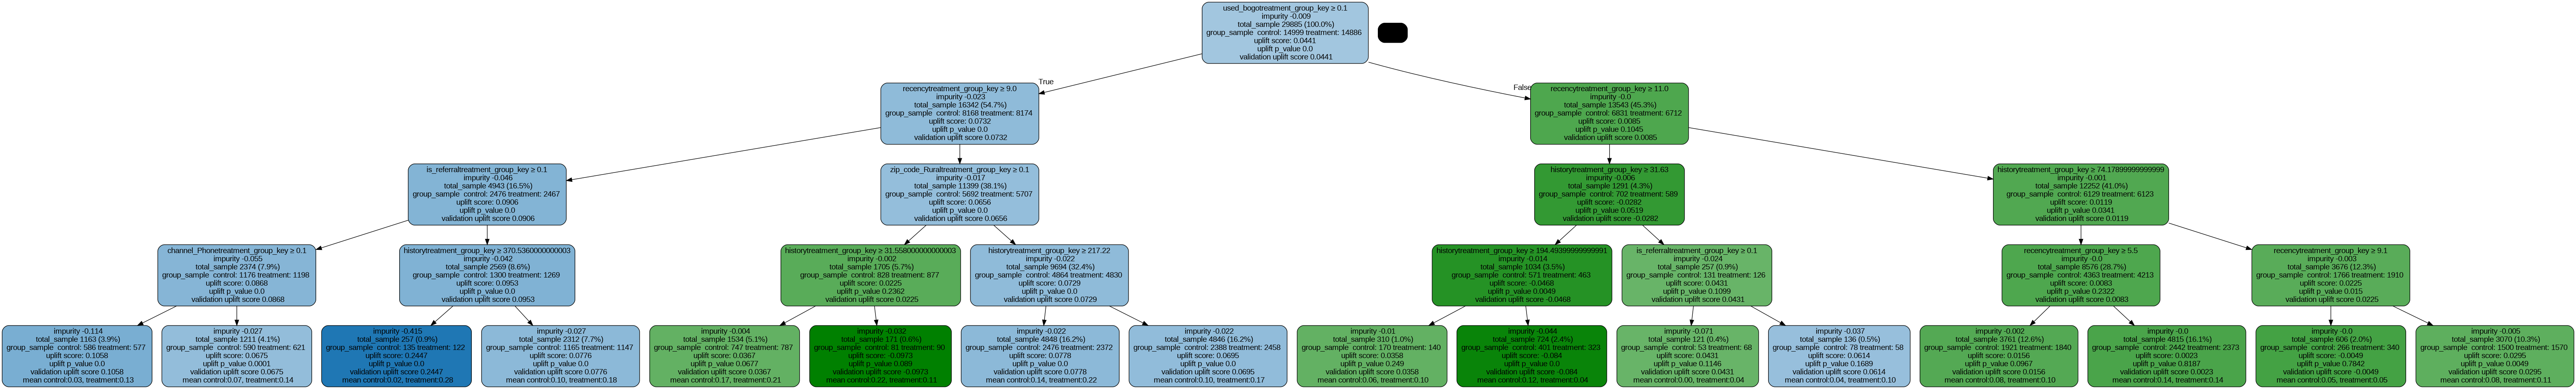

In [162]:
# Plot uplift tree
from IPython.display import Image
graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree, X_train.columns)
Image(graph.create_png())

In [163]:
uplift_results = pd.DataFrame(y_pred, columns=uplift_rf.classes_[1:])

best_treatment = np.where(uplift_results['treatment'] < 0, 'control', 'treated')

auuc_metrics = (uplift_results.assign(is_treated=(treatment_test.values != 'control').astype(int),
                              conversion=pd.concat([X_test, y_test, treatment_test], axis=1)['target'].values,
                              uplift=uplift_results.max(axis=1))
                .drop(columns=list(uplift_rf.classes_[1:])))

# Print AUUC metrics DataFrame
print("AUUC metrics DataFrame:")
display(auuc_metrics)

AUUC metrics DataFrame:


,is_treated,conversion,uplift
0,0,0,0.041532
1,1,0,0.013434
2,1,0,0.039419
3,1,0,0.070168
4,0,0,0.073419
...,...,...,...
12803,0,0,0.089943
12804,1,0,-0.012669
12805,1,0,0.015666
12806,0,0,0.018936


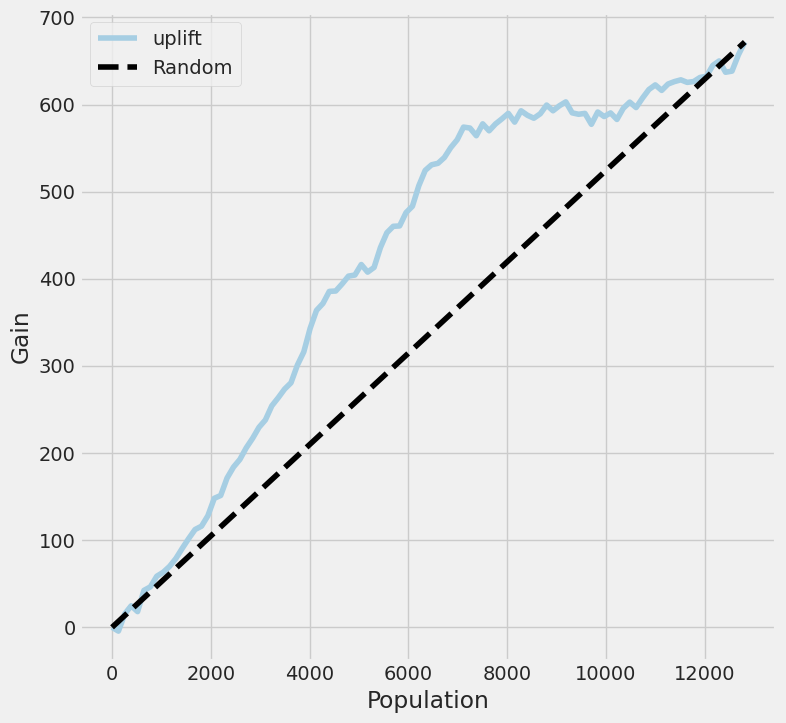

In [164]:
# Plot the uplift curve
from causalml.metrics import plot_gain, plot_qini
plot_gain(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')

In [165]:
from causalml.metrics import auuc_score
score = auuc_score(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')
print(score)

uplift    0.632501
dtype: float64
